In [1]:
#Imports are go

%gui qt

#Usual suspects
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
import seaborn as sns

#We all know this
import sklearn

#Imaging specific 
import nibabel as nib
import nipype
from nipype.interfaces.image import Reorient
import ants
import antspynet

#Visualisation
import napari

#Sys biz
import glob
import os
import sys

/opt/miniconda/envs/neuro/lib/python3.8/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


# Outline:

## Loading nifti data
## Manipulation 
## Bias correction
## Creating brain mask
## Skull Strip
## Tissue Segmentation
## Template Space transform

In [2]:
#Setup

data_dir = 'nii'

## Load nifti data

In [3]:
ex_fn = glob.glob(os.path.join(data_dir, 'ex.nii*'))[0]
ex = nib.load(ex_fn)
ex_data = ex.get_fdata()

print(ex.shape)
print(np.product(ex.shape))
print(ex.header.get_zooms())

print('Minimum intensity value = {}'.format(ex_data.min()))
print('Maximum intensity value = {}'.format(ex_data.max()))

vmin = 0
vmax = ex_data.max() // 2

(256, 256, 176)
11534336
(1.0, 1.0, 1.0)
Minimum intensity value = 0.0
Maximum intensity value = 1933.0


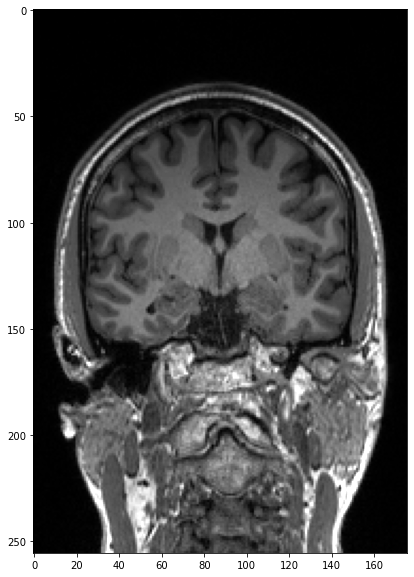

In [4]:
fig, ax = plt.subplots(1,1,figsize = [10, 10])
ax.imshow(np.rot90(ex_data[125, :, :], 2), 
          cmap = 'gray', 
          vmin = vmin, 
          vmax = vmax)

('P', 'S', 'R')


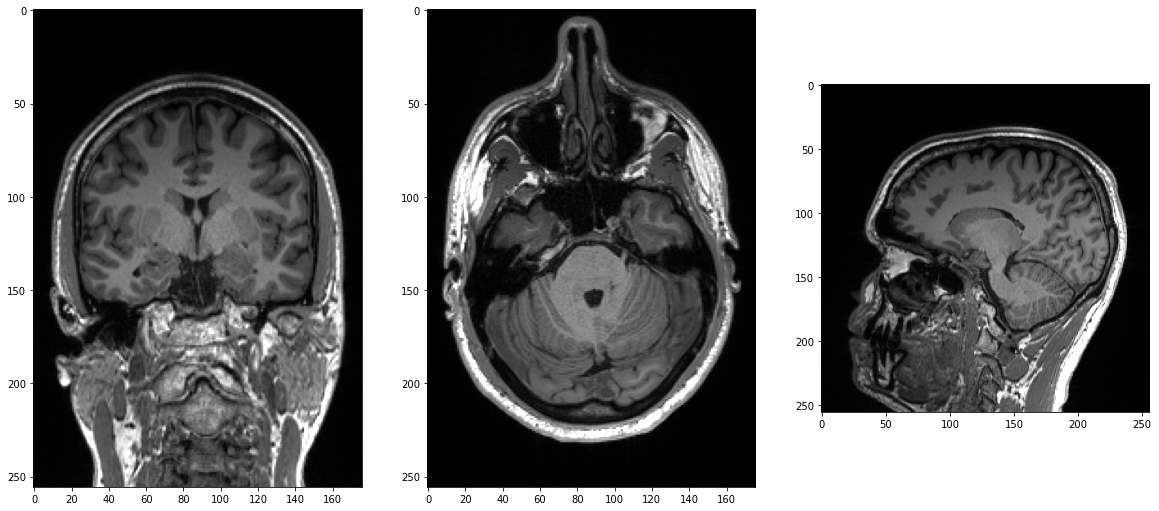

In [5]:
fig, ax = plt.subplots(1,3, figsize = [20, 10]);

ax[0].imshow(np.rot90(ex_data[125, :, :], 2), cmap = 'gray', vmin = vmin, vmax = vmax)
ax[1].imshow(ex_data[:, 100, :], cmap = 'gray', vmin = vmin, vmax = vmax)
ax[2].imshow(np.rot90(ex_data[:, :, 100]), cmap = 'gray', vmin = vmin, vmax = vmax)

print(nib.aff2axcodes(ex.affine))

('R', 'A', 'S')
(176, 256, 256)


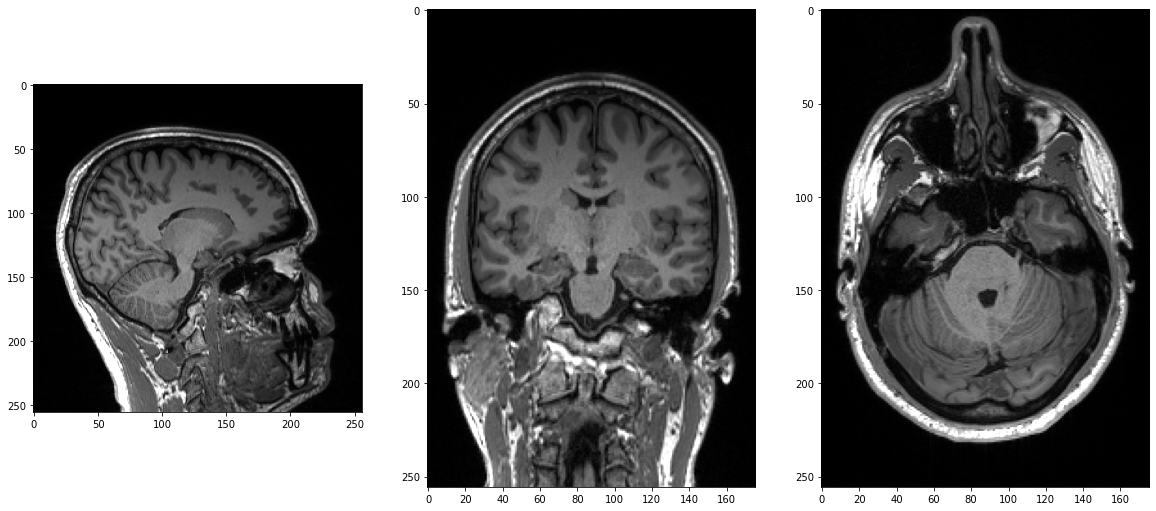

In [6]:
reorient = Reorient(orientation = 'RAS')
reorient.inputs.in_file = ex_fn
res = reorient.run()
os.rename(res.outputs.out_file, os.path.join('nii', 'ex_ras.nii.gz'))

ex_ras = nib.load(os.path.join('nii', 'ex_ras.nii.gz'))
ex_ras_data = ex_ras.get_fdata()
print(nib.aff2axcodes(ex_ras.affine))
print(ex_ras_data.shape)

vmin = 0
vmax = ex_data.max() // 2

fig, ax = plt.subplots(1,3, figsize = [20, 10]);
ax[0].imshow(np.rot90(ex_ras_data[100, :, :]), cmap = 'gray', vmin = vmin, vmax = vmax);
ax[1].imshow(np.rot90(ex_ras_data[:, 125, :], 1), cmap = 'gray', vmin = vmin, vmax = vmax);
ax[2].imshow(np.rot90(ex_ras_data[:, :, 100]), cmap = 'gray', vmin = vmin, vmax = vmax);

## Bias correction

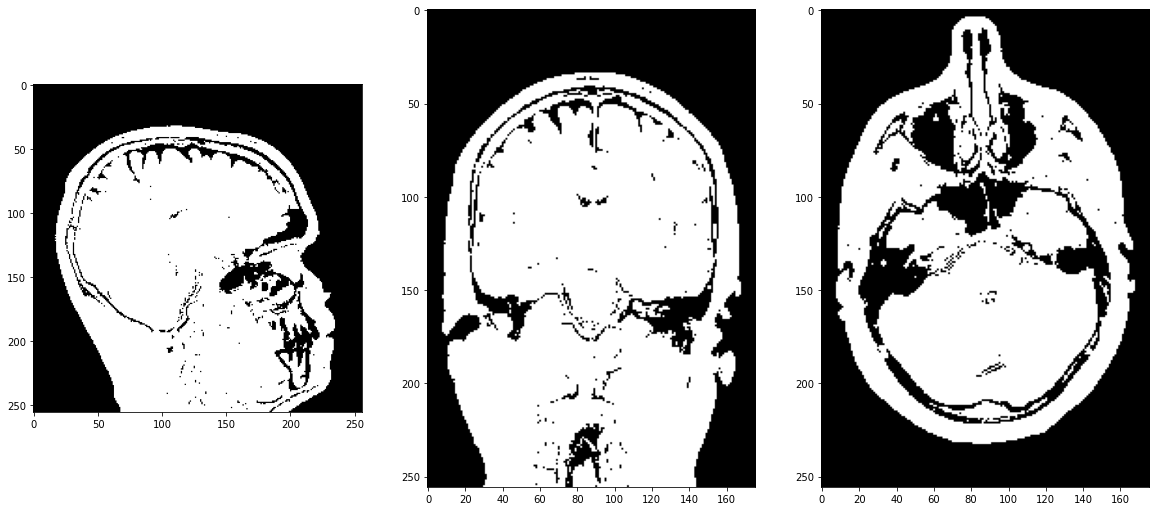

In [7]:
mask = (ex_ras_data > 90).astype(int)

fig, ax = plt.subplots(1,3, figsize = [20, 10]);
ax[0].imshow(np.rot90(mask[100, :, :]), cmap = 'gray');
ax[1].imshow(np.rot90(mask[:, 125, :], 1), cmap = 'gray');
ax[2].imshow(np.rot90(mask[:, :, 100]), cmap = 'gray');

In [8]:
mask_nii = nib.Nifti1Image(mask, affine = ex_ras.affine, header = ex_ras.header)
mask_ants = ants.from_nibabel(mask_nii)

ex_ras_ants = ants.from_nibabel(ex_ras)
ex_n4_ants = ants.n4_bias_field_correction(ex_ras_ants, 
                                           mask = mask_ants, 
                                           verbose = True)
ex_n4 = ex_n4_ants.to_nibabel()
ex_n4_data = ex_n4.get_fdata()

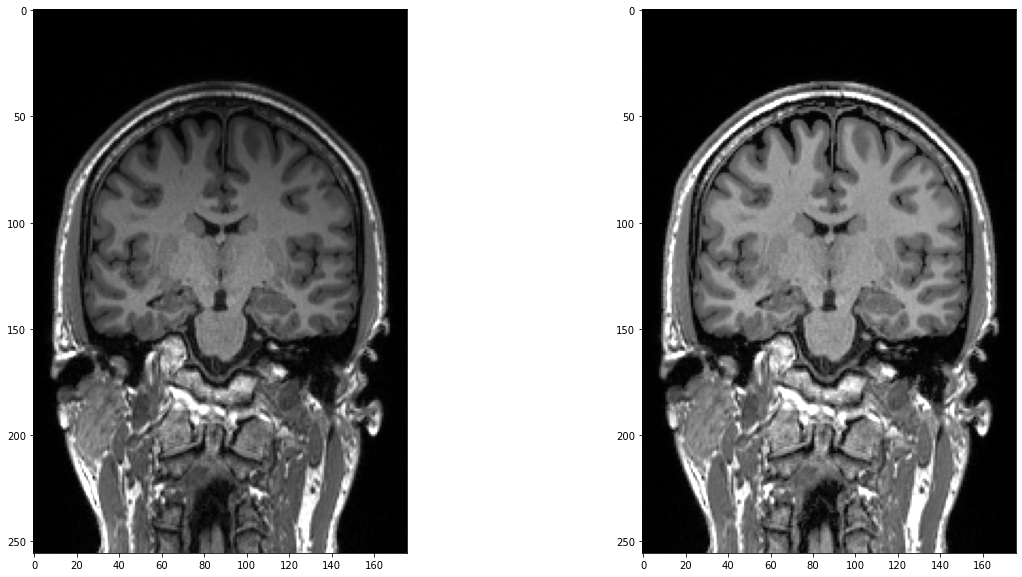

In [9]:
fig, ax = plt.subplots(1,2, figsize = [20, 10])
ax[0].imshow(np.rot90(ex_ras_data[:, 125, :]), cmap = 'gray', vmin = vmin, vmax = vmax)
ax[1].imshow(np.rot90(ex_n4_data[:, 125, :]), cmap = 'gray', vmin = vmin, vmax = vmax)

In [10]:
viewer = napari.view_image(ex_n4_data, 
                           name = 'mri', 
                           rendering = 'attenuated_mip', 
                           attenuation = 1, 
                           colormap = 'gray', 
                           interpolation = 'nearest', 
                           rotate=90)

In [11]:
ex_n4_data_25 = ex_n4_data > ex_n4_data.max() * 0.25
viewer.add_image(ex_n4_data_25, 
                 name = '25% mask', 
                 rotate = 90, 
                 colormap = 'blue', 
                 opacity = 0.3)

<Image layer '25% mask' at 0x7fda30393a00>

## Brain extraction

In [12]:
ex_brain_mask_ants = antspynet.utilities.brain_extraction(ex_n4_ants, 
                                                          modality = 't1'); #Downloads TF model (H5 + template file)

ex_brain_mask = ants.to_nibabel(ex_brain_mask_ants) #Probability map
ex_brain_mask_data = ex_brain_mask.get_fdata()
ex_brain_mask_data = ex_brain_mask_data >= 0.95

#Make new nifti1 object:

ex_brain_mask = nib.Nifti1Image(ex_brain_mask_data, 
                                header = ex_brain_mask.header, 
                                affine = ex_brain_mask.affine)

ex_brain_mask.to_filename((os.path.join(data_dir, 'ex_brain_mask.nii.gz')))

In [13]:
viewer = napari.view_image(ex_brain_mask_data, 
                           name = 'mask', 
                           rendering = 'attenuated_mip', 
                           attenuation = 1, 
                           colormap = 'red', 
                           interpolation = 'nearest',
                           rotate = 90)

viewer.add_image(ex_n4_data, 
                 name = 'mri', 
                 opacity = 0.50, 
                 rotate = 90)

<Image layer 'mri' at 0x7fda3036ff10>

In [14]:
reorient = Reorient(orientation = 'RAS')
reorient.inputs.in_file = os.path.join('nii', 'ex_bet_mask.nii.gz')
res = reorient.run()
os.rename(res.outputs.out_file, os.path.join('nii', 'ex_bet_ras_mask.nii.gz'))

bet_mask = nib.load(os.path.join('nii', 'ex_bet_ras_mask.nii.gz'))
bet_mask_data = bet_mask.get_fdata()


viewer.add_image(bet_mask_data, name = 'bet_mask', opacity = 0.50, colormap = 'blue', rotate = 90)

<Image layer 'bet_mask' at 0x7fd9ff0498e0>

In [15]:
#Remove skull using brain mask

idx = np.where(ex_brain_mask_data == 1)
ex_brain_data = np.zeros_like(ex_brain_mask_data).astype(float)
ex_brain_data[idx] = ex_n4_data[idx]
ex_brain = nib.Nifti1Image(ex_brain_data, 
                           affine = ex_n4.affine, 
                           header = ex_n4.header)
ex_brain.to_filename((os.path.join(data_dir, 'ex_brain.nii.gz')))

In [16]:
viewer = napari.view_image(ex_brain_data, 
                           name = 'brain', 
                           rendering = 'attenuated_mip', 
                           attenuation = 1, 
                           colormap = 'gray', 
                           interpolation = 'nearest',
                           rotate = 90)

viewer.add_image(ex_brain_mask_data, 
                 name = 'mask', 
                 colormap = 'red', 
                 opacity = 0.50, 
                 rotate = 90)

<Image layer 'mask' at 0x7fd9e81869d0>

## Segmentation

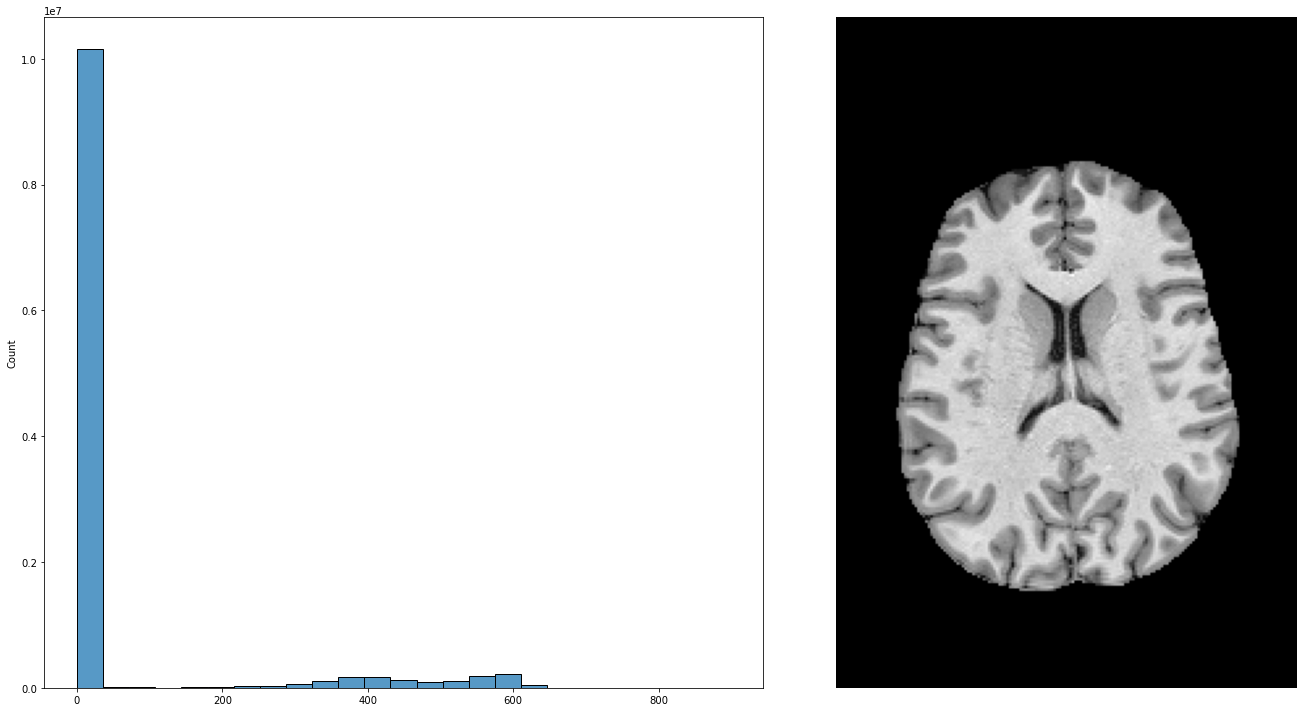

In [17]:
flat_brain = np.ravel(ex_brain_data)

fig, ax = plt.subplots(1,2, figsize = [20, 10])
sns.histplot(flat_brain, ax = ax[0])
ax[1].imshow(np.rot90(ex_brain_data[:, :, 150]), cmap = 'gray')
ax[1].axis('off')
plt.tight_layout()

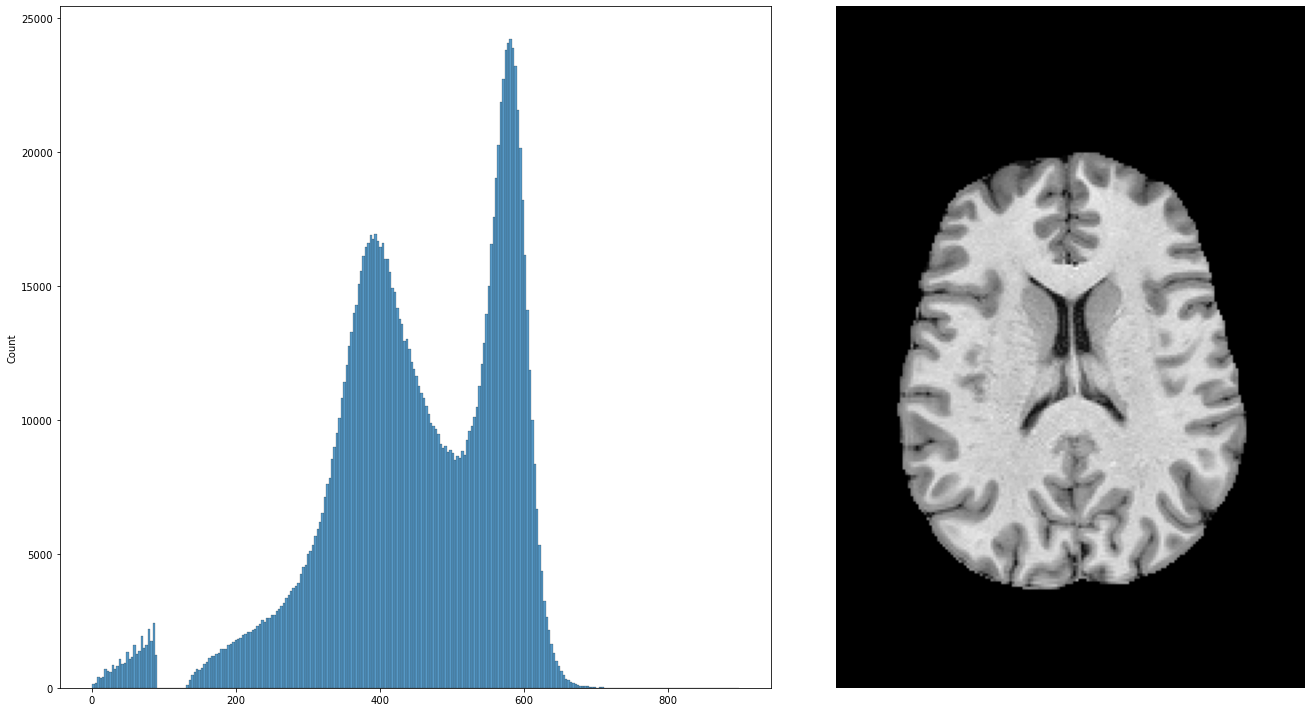

In [18]:
fig, ax = plt.subplots(1,2, figsize = [20, 10])
sns.histplot(flat_brain[flat_brain > 0], ax = ax[0])
ax[1].imshow(np.rot90(ex_brain_data[:, :, 150]), cmap = 'gray')
ax[1].axis('off')
plt.tight_layout()

In [19]:
X = flat_brain.reshape(-1, 1)
print(X)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [20]:
X.shape

(11534336, 1)

In [21]:
km = sklearn.cluster.KMeans(n_clusters = 4, random_state = 1010)
km.fit(X)
km_out = km.predict(X)

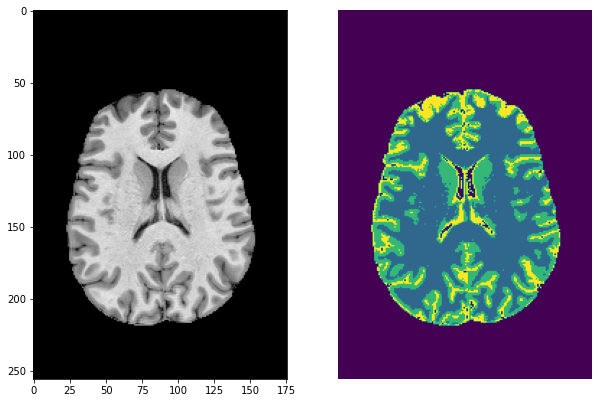

In [22]:
rebrain_data = km_out.reshape(ex_brain_data.shape)
fig, ax = plt.subplots(1,2,figsize = [10,15])
ax[0].imshow(np.rot90(ex_brain_data[:, :, 150]), cmap = 'gray')
ax[1].axis('off')
ax[1].imshow(np.rot90(rebrain_data[:, :, 150]), cmap = 'viridis')
ax[1].axis('off')

rebrain = nib.Nifti1Image(rebrain_data, 
                          affine = ex_brain.affine, 
                          header = ex_brain.header)

rebrain.to_filename((os.path.join(data_dir, 'ex_seg.nii.gz')))

In [23]:
viewer = napari.view_image(rebrain_data, 
                           name = 'brain', 
                           rendering = 'attenuated_mip', 
                           attenuation = 1, 
                           colormap = 'gray', 
                           interpolation = 'nearest',
                           rotate = 90)

In [24]:
c0 = np.where(km_out == 0)[0] #BG
c1 = np.where(km_out == 1)[0] #WM
c2 = np.where(km_out == 2)[0] #GM
c3 = np.where(km_out == 3)[0] #CSF

cs = [c0, c1, c2, c3]

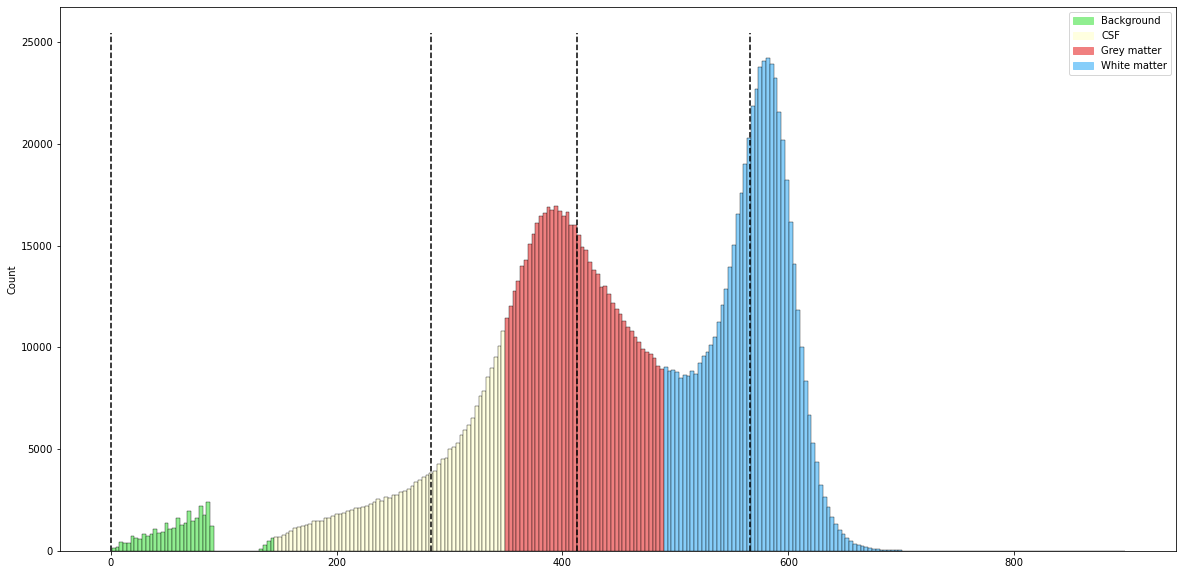

In [25]:
fig, ax = plt.subplots(1,1, figsize = [20, 10])
sns.histplot(flat_brain[flat_brain > 0], ax = ax)
ymin, ymax = ax.axes.get_ybound()

for rec in ax.patches:
    if rec.get_x() <= flat_brain[c0].max():
        rec.set_facecolor('lightgreen')

    elif rec.get_x() >= flat_brain[c3].min() and rec.get_x() <= flat_brain[c3].max():
        rec.set_facecolor('lightyellow')
        
    elif rec.get_x() >= flat_brain[c1].min():
        rec.set_facecolor('lightskyblue')
        
    elif rec.get_x() >= flat_brain[c2].min() and rec.get_x() <= flat_brain[c2].max():
        rec.set_facecolor('lightcoral')
        

for m in km.cluster_centers_:
    ax.vlines(m, ymin, ymax, colors = 'k', linestyles = 'dashed', label = m)

bg = mpatches.Patch(color = 'lightgreen', label = 'Background')
grey = mpatches.Patch(color = 'lightcoral', label = 'Grey matter')
wm = mpatches.Patch(color = 'lightskyblue', label = 'White matter')
csf = mpatches.Patch(color = 'lightyellow', label = 'CSF')
plt.legend(handles = [bg, csf, grey, wm]);

## Template Space transform

In [26]:
#Affine transform brain from subject space to template (MNI) space

mni_fn = os.path.join('nii', 'mni152_t1_1mm_brain.nii.gz')
mni = nib.load(mni_fn)
mni_data = mni.get_fdata()

mni_mask_data = mni.get_fdata() > 1 #Create a quick brain mask
mni_mask = nib.Nifti1Image(mni_mask_data, 
                           affine = mni.affine, 
                           header = mni.header)
mni_ants = ants.from_nibabel(mni)

ex_brain = nib.load(os.path.join('nii', 'ex_brain.nii.gz'))

ex_brain_ants = ants.from_nibabel(ex_brain)
reg = ants.registration(mni_ants, ex_brain_ants, 'AffineFast', verbose = True)
ex_brain_mni_ants = reg['warpedmovout']
ex_brain_mni = ants.to_nibabel(ex_brain_mni_ants)
ex_brain_mni_data = ex_brain_mni.get_fdata()


subj2mni_affine = ants.read_transform(reg['fwdtransforms'][0])
ex_brain_mni.to_filename(os.path.join('nii', 'ex_brain_mni.nii.gz'))

In [27]:
viewer = napari.view_image(mni_data, 
                           name = 'mni template', 
                           rendering = 'attenuated_mip', 
                           attenuation = 1, 
                           colormap = 'gray', 
                           interpolation = 'nearest',
                           rotate = 90)

viewer.add_image(ex_brain_data, 
                 name = 'subject space', 
                 colormap = 'red', 
                 opacity = 0.50, 
                 rotate = 90)

<Image layer 'subject space' at 0x7fd9f826bc70>

In [28]:
viewer.add_image(ex_brain_mni_data,
                 name = 'mni space', 
                 colormap = 'blue', 
                 opacity = 0.50, 
                 rotate = 90)

<Image layer 'mni space' at 0x7fd9d07515b0>

In [29]:
#Apply transform to output from kmeans

rebrain = nib.load(os.path.join('nii', 'ex_seg.nii.gz'))

rebrain_ants = ants.from_nibabel(rebrain)
rebrain_mni_ants = ants.apply_ants_transform_to_image(subj2mni_affine, 
                                                      rebrain_ants, 
                                                      mni_ants, 
                                                      interpolation = 'nearestneighbor')


rebrain_mni = rebrain_mni_ants.to_nibabel()
rebrain_mni_data = rebrain_mni.get_fdata()

In [30]:
viewer = napari.view_image(mni_ants.numpy(), 
                           name = 'segment mni', 
                           rendering = 'attenuated_mip', 
                           attenuation = 1, 
                           colormap = 'gray', 
                           interpolation = 'nearest',
                           rotate = 90)

viewer.add_image(rebrain_mni_data, 
                 name = 'mni space', 
                 colormap = 'viridis', 
                 opacity = 0.50, 
                 rotate = 90)

<Image layer 'mni space' at 0x7fd9bc3b98b0>